# Mapping, Segmenting, and Clustering Brooklyn's Neighborhoods

Imagine you're a retailer, restaurant, bar, or salon looking for the best spot for a new location in Brooklyn. Or, let's say you're simply someone looking to move to Brooklyn and want to know which neighborhoods (or groups of areas) you would like most. Mapping, segmenting, and clustering geospatial data could be a big help. Today, we'll work with geospatial data on New York City, focusing in on Brooklyn (where I used to live), to create interactive zoom & pop-up maps, explore Brooklyn venues with the Foursquare API, segment Brooklyn neighborhoods and their venues, and cluster Brooklyn venues using k-means clustering. Original source for geo json data can be found here: https://geo.nyu.edu/catalog/nyu_2451_34572. Let's break it down:       

**Part 1**: Open json from url, including using urllib.request.open and json.load
<br>**Part 2**: Transform json into dataframe, including pulling relevant data from json and constructing new dataframe
<br>**Part 3**: Visualize NYC with interactive map, including geocoding using geopy and folium to create an interactive zoom & pop-up map
<br>**Part 4**: Visualize Brooklyn with interactive map, including geocoding using geopy and folium to create an interactive zoom & pop-up map
<br>**Part 5**: Explore venues using Foursquare API, including making calls to the API for a single neighborhood (Crown Heights), defining functions for extracting categories, and creating dataframe of venues in a specified radius with their latitude and longitude coordinate and category
<br>**Part 6**: Segment Brooklyn neighborhoods, including creating function to get nearby venues calling Foursquare API, creating dataframe of venues in a specified radius with their latitude and longitude coordinate and category, grouping data by neighborhood, one hot encoding venue categories, obtain top 10 venue categories for each neighborhood and create dataframe
<br>**Part 7**: Clustering Brooklyn neighborhoods, including optimizing k for k-means clustering by plotting wcss vs k value, fitting k-means clustering model, creating dataframe with cluster labels, and creating interactive map of clusters using folium
<br>**Part 8**: Examine each cluster, including creating dataframe for each cluster and making observations 

Remember, k-means clustering depends a lot on the initialization of centroids. Since this is set by us and can differ each time, k-means clustering leads to a different result each time we run it (local optimum rather than a global optimum). Here we use the "k-means++" initialization and set the number of times the k-means algorithm will be run with different centroids (n_init) as 12. Scikit learn's "k-means++" initializes the centroids to be (generally) distant from each other, leading to provably better results than random initialization (e.g., random_state). Check out this paper for more information (http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf). As always, it's great to dig into scikit learn's documentation, here it is for clustering: https://scikit-learn.org/stable/modules/clustering.html.

In [1]:
# Import relevant libraries
import requests # handle requests
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import style
import random # random number generation

!pip install geopy
from geopy.geocoders import Nominatim # convert address into latitude and longitude

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
import urllib.request 
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

!pip install folium
import folium
from folium import plugins 

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib.cm as cm
import matplotlib.colors as colors

# Import k-means from clustering
from sklearn.cluster import KMeans

     |████████████████████████████████| 102kB 10.5MB/s ta 0:00:01


## Part 1: Load Json Data from Url

In [2]:
# Load json data from url
with urllib.request.urlopen("https://cocl.us/new_york_dataset") as url:
    ny = json.loads(url.read().decode())

In [3]:
# Create variable neighborhoods_data that includes just neighborhood data, which is found in the json file's features' key
neighborhoods_data = ny['features']
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

## Part 2: Transform Json Data into Dataframe

In [4]:
# Empty array with column names
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# Instantiate dataframe
neighborhoods = pd.DataFrame(columns = column_names)

neighborhoods

,Borough,Neighborhood,Latitude,Longitude


#### Build neighborhoods dataframe

In [5]:
# Pull in respective data from json using for loop
for data in neighborhoods_data:
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
    neighborhood_latlong = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlong[1]
    neighborhood_long = neighborhood_latlong[0]
    
    # Fill neighborhoods dataframe we created above with data
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_long}, ignore_index=True)

In [6]:
# Check first few rows for our newly created neighborhoods dataframe
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [7]:
# Print number of unique boroughs and total neighborhoods in our dataframe. We have 5 unique boroughs and 306 total neighborhoods
print('New York City has {} boroughs and {} neighborhoods.'.format(len(neighborhoods['Borough'].unique()), neighborhoods.shape[0]))

New York City has 5 boroughs and 306 neighborhoods.


## Part 3: Visualize NYC with Interactive Map

In [8]:
# Use geopy to obtain latitude and longitude of NYC 
address = 'New York City, NY'
geolocator = Nominatim(user_agent="ny_explorer") # Need to define user_agent in order to instantiate geocoder. Here we use ny_explorer as the name of the user_agent
location = geolocator.geocode(address)
lat = location.latitude
long = location.longitude

print('The latitude and longitude of New York City are {}, {}.'.format(lat, long))

The latitude and longitude of New York City are 40.7127281, -74.0060152.


In [9]:
# Visualize NYC with interactive zoom and pop-up map using folium and latitude, longitude values we obtained above
map_nyc = folium.Map(location=[lat, long], zoom_start=11)

# Add markers to map
for lat, long, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=6,
        popup=label,
        color='gray',
        fill=True,
        fill_color='#3edbfa',
        fill_opacity=0.7,
        parse_html=False).add_to(map_nyc)  
    
map_nyc

## Part 4: Visualize Brooklyn with Interactive Map

In [10]:
# Create new dataframe of just manhattan
brooklyn = neighborhoods[neighborhoods['Borough'] == 'Brooklyn'].reset_index(drop=True)
brooklyn.head()

,Borough,Neighborhood,Latitude,Longitude
0,Brooklyn,Bay Ridge,40.625801,-74.030621
1,Brooklyn,Bensonhurst,40.611009,-73.995180
2,Brooklyn,Sunset Park,40.645103,-74.010316
3,Brooklyn,Greenpoint,40.730201,-73.954241
4,Brooklyn,Gravesend,40.595260,-73.973471


In [11]:
# Use geopy to get latitude and longitude of Brooklyn. 
address = 'Brooklyn, NY'
geolocator = Nominatim(user_agent="ny_explorer") # Need to define user_agent in order to instantiate geocoder. Here we use ny_explorer as the name of the user_agent
location = geolocator.geocode(address)
lat = location.latitude
long = location.longitude

print('The geograpical coordinate of Brooklyn are {}, {}.'.format(lat, long))

The geograpical coordinate of Brooklyn are 40.6501038, -73.9495823.


In [43]:
# Visualize Brooklyn with interactive zoom and pop-up map using folium and latitude, longitude values we got above
map_brooklyn = folium.Map(location=[lat, long], zoom_start=11)

# Add markers to map
for lat, long, label in zip(brooklyn['Latitude'], brooklyn['Longitude'], brooklyn['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=6,
        popup=label,
        color='gray',
        fill=True,
        fill_color='#3edbfa',
        fill_opacity=0.7,
        parse_html=False).add_to(map_brooklyn)  
    
map_brooklyn

## Part 5: Explore Brooklyn Venues Using Foursquare API

In [13]:
# My FourSquare API developer credentials
CLIENT_ID = "NG3X0JN3OQ3HMM4VWINRT4ZGUXB2B5BQ2LHMORUZQJJ534AO"
CLIENT_SECRET = "I3IXTMACE1HX4PGU2FXCVI1CZHUKUKYQC0MUAOMI3KWYNOHC"
VERSION = '20180604'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: NG3X0JN3OQ3HMM4VWINRT4ZGUXB2B5BQ2LHMORUZQJJ534AO
CLIENT_SECRET:I3IXTMACE1HX4PGU2FXCVI1CZHUKUKYQC0MUAOMI3KWYNOHC


In [14]:
# Randomly select 10th neighborhood in Brooklyn dataframe. It's Crown Heights
brooklyn.loc[9, 'Neighborhood']

'Crown Heights'

In [15]:
# Get latitude and longitude of Crown Heights, the 10th neighborhood in our dataframe
neighborhood_lat = brooklyn.loc[9, 'Latitude'] 
neighborhood_long = brooklyn.loc[9, 'Longitude']
neighborhood_name = brooklyn.loc[9, 'Neighborhood']

print('The latitude and longitude of {} are {}, {}.'.format(neighborhood_name, neighborhood_lat, neighborhood_long))

The latitude and longitude of Crown Heights are 40.67082917695294, -73.94329119073582.


In [16]:
# Using the FourSquare API, let's get the top 200 venues within a 500 meter radius in Crown Heights

# Set variables for venue limit and radius
limit = 200 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

# Create url for API request using our credentials and Crown Heights data above
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, neighborhood_lat, neighborhood_long, radius, limit)
url 

'https://api.foursquare.com/v2/venues/explore?&client_id=NG3X0JN3OQ3HMM4VWINRT4ZGUXB2B5BQ2LHMORUZQJJ534AO&client_secret=I3IXTMACE1HX4PGU2FXCVI1CZHUKUKYQC0MUAOMI3KWYNOHC&v=20180604&ll=40.67082917695294,-73.94329119073582&radius=500&limit=200'

In [17]:
# Use .get to get json from url
results = requests.get(url).json()

In [18]:
# Define function that extracts the category of the venue from our json
def get_category(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [19]:
# Convert json to dataframe
venues = results['response']['groups'][0]['items']
    
# Flatten json for dataframe    
nearby_venues = json_normalize(venues)

# Filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

# Filter the category for each row using the get_category function we defined above
nearby_venues['venue.categories'] = nearby_venues.apply(get_category, axis=1)

# Clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Jewish Children's Museum,Museum,40.669017,-73.942086
1,Brower Park,Playground,40.673453,-73.943493
2,Sweet Expressions,Candy Store,40.668382,-73.942337
3,Basil Pizza & Wine Bar,Pizza Place,40.670358,-73.942162
4,Calabria,Pizza Place,40.670420,-73.942230


In [20]:
# Let's see how many venues we have for the neighborhood Crown Heights. We have 20
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

20 venues were returned by Foursquare.


## Part 6: Segment Brooklyn Neighborhoods with their Venues

In [21]:
# We've explored just the neighborhood Crown Heights in Brooklyn. Let's use the Foursquare API to pull a list of venues in all of Brooklyn

# Define function get_nearby_venues 
def get_nearby_venues(names, latitude, longitude):
    
    # Create empty array venues_list
    venues_list=[]
    
    for name, lat, long in zip(names, latitude, longitude):
        print(name) 
        
        # Create url for API request
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, long, radius, limit)

        # Make the get request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # Fill venues_list with relevant info from json
        venues_list.append([(
            name, 
            lat, 
            long, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    
    # Create dataframe with info and appropriate column headings
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood','Neighborhood Latitude','Neighborhood Longitude','Venue','Venue Latitude','Venue Longitude','Venue Category']
    
    return(nearby_venues)

In [22]:
brooklyn_venues = get_nearby_venues(names = brooklyn['Neighborhood'], latitude = brooklyn['Latitude'], longitude = brooklyn['Longitude'])

Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker Heights
Gerritsen Beach
Marine Park
Clinton Hill
Sea Gate
Downtown
Boerum Hill
Prospect Lefferts Gardens
Ocean Hill
City Line
Bergen Beach
Midwood
Prospect Park South
Georgetown
East Williamsburg
North Side
South Side
Ocean Parkway
Fort Hamilton
Ditmas Park
Wingate
Rugby
Remsen Village
New Lots
Paerdegat Basin
Mill Basin
Fulton Ferry
Vinegar Hill
Weeksville
Broadway Junction
Dumbo
Homecrest
Highland Park
Madison
Erasmus


In [23]:
# Check dimensions of brooklyn venues dataframe. We have 2,743 venues and 7 variables
print(brooklyn_venues.shape)
brooklyn_venues.head()

(2743, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bay Ridge,40.625801,-74.030621,Pilo Arts Day Spa and Salon,40.624748,-74.030591,Spa
1,Bay Ridge,40.625801,-74.030621,Bagel Boy,40.627896,-74.029335,Bagel Shop
2,Bay Ridge,40.625801,-74.030621,Cocoa Grinder,40.623967,-74.030863,Juice Bar
3,Bay Ridge,40.625801,-74.030621,Leo's Casa Calamari,40.624200,-74.030931,Pizza Place
4,Bay Ridge,40.625801,-74.030621,Pegasus Cafe,40.623168,-74.031186,Breakfast Spot


In [24]:
# Check number of unique venue categories. We have 285
print('There are {} uniques categories.'.format(len(brooklyn_venues['Venue Category'].unique())))

There are 285 uniques categories.


In [25]:
# Check number of venues by neighborhood
brooklyn_venues.groupby("Neighborhood").count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Bath Beach,53,53,53,53,53,53
Bay Ridge,80,80,80,80,80,80
Bedford Stuyvesant,29,29,29,29,29,29
Bensonhurst,29,29,29,29,29,29
Bergen Beach,5,5,5,5,5,5
Boerum Hill,89,89,89,89,89,89
Borough Park,20,20,20,20,20,20
Brighton Beach,44,44,44,44,44,44
Broadway Junction,15,15,15,15,15,15


In [26]:
# One hot encoding venue categories creates binary dummy varable for each category
brooklyn_onehot = pd.get_dummies(brooklyn_venues[['Venue Category']], prefix="", prefix_sep="")

# Add neighborhood column to newly created one hot encoded dataframe
brooklyn_onehot['Neighborhood'] = brooklyn_venues['Neighborhood'] 

# Move neighborhood column to the first column
fixed_columns = [brooklyn_onehot.columns[-1]] + list(brooklyn_onehot.columns[:-1])
brooklyn_onehot = brooklyn_onehot[fixed_columns]

brooklyn_onehot.head()

,Yoga Studio,Accessories Store,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,History Museum,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Insurance Office,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Latin American Restaurant,Laundromat,Laundry Service,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoors & Recreation,Outlet Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Pub,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,Rock Club,Roller Rink,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skating Rink,Ski Area,Smoke Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Toy / Game Store,Trail,Turkish Restaurant,Used Bookstore,Vape Store,Varenyky restaura

In [27]:
# Check dimension of one hot encoded dataframe
brooklyn_onehot.shape

(2743, 285)

In [28]:
# Let's look at frequency of venue category in each neighborhood (there are many neighbor hoods and nearly 300 categories so values will mostly beclose to 0)
brooklyn_grouped = brooklyn_onehot.groupby('Neighborhood').mean().reset_index()
brooklyn_grouped

,Neighborhood,Yoga Studio,Accessories Store,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,History Museum,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Insurance Office,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Latin American Restaurant,Laundromat,Laundry Service,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoors & Recreation,Outlet Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Pub,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,Rock Club,Roller Rink,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skating Rink,Ski Area,Smoke Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Toy / Game Store,Trail,Turkish Restaurant,Used Bookstore,Vape Store,Varenyky restaura

In [29]:
# Let's look at the top 5 venues and their category an frequency in each neighborhood
num_top_venues = 5

for hood in brooklyn_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = brooklyn_grouped[brooklyn_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bath Beach----
                venue  freq
0         Pizza Place  0.06
1            Pharmacy  0.06
2  Chinese Restaurant  0.04
3    Halal Restaurant  0.04
4          Donut Shop  0.04


----Bay Ridge----
                 venue  freq
0                  Spa  0.08
1   Italian Restaurant  0.06
2          Pizza Place  0.05
3  American Restaurant  0.04
4     Greek Restaurant  0.04


----Bedford Stuyvesant----
           venue  freq
0    Coffee Shop  0.10
1    Pizza Place  0.07
2  Deli / Bodega  0.07
3            Bar  0.07
4           Café  0.07


----Bensonhurst----
                venue  freq
0  Chinese Restaurant  0.14
1          Donut Shop  0.07
2    Sushi Restaurant  0.07
3  Italian Restaurant  0.07
4                Park  0.07


----Bergen Beach----
                venue  freq
0     Harbor / Marina   0.4
1      Baseball Field   0.2
2          Playground   0.2
3  Athletics & Sports   0.2
4     Organic Grocery   0.0


----Boerum Hill----
                    venue  freq
0            Danc

In [30]:
# Let's look at the most common types of venues by first defining a function
def most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [31]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# Create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# Create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = brooklyn_grouped['Neighborhood']

for ind in np.arange(brooklyn_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = most_common_venues(brooklyn_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bath Beach,Pizza Place,Pharmacy,Halal Restaurant,Donut Shop,Sushi Restaurant,Fast Food Restaurant,Chinese Restaurant,Bubble Tea Shop,Gas Station,Dessert Shop
1,Bay Ridge,Spa,Italian Restaurant,Pizza Place,American Restaurant,Greek Restaurant,Bagel Shop,Bar,Hookah Bar,Pharmacy,Thai Restaurant
2,Bedford Stuyvesant,Coffee Shop,Bar,Café,Pizza Place,Deli / Bodega,Juice Bar,Bus Stop,Fried Chicken Joint,Boutique,New American Restaurant
3,Bensonhurst,Chinese Restaurant,Sushi Restaurant,Ice Cream Shop,Donut Shop,Park,Italian Restaurant,Hotpot Restaurant,Shabu-Shabu Restaurant,Liquor Store,Supermarket
4,Bergen Beach,Harbor / Marina,Playground,Athletics & Sports,Baseball Field,Women's Store,Fish & Chips Shop,Farm,Farmers Market,Fast Food Restaurant,Field


## Part 7: Clustering Brooklyn Neighborhoods

Let's cluster our venue categories using k means clustering, which is based on euclidian distance and clusters points around centroids that minimize within cluster sum of squares, wcss (how internally coherent clusters are). We'll need to decide on the number of clusters we want to use. To determine our optimal k, let's choose k that minizes wcss and pick the 'elbow point' in our plot. 

We see that in our plot, it's difficult to see a clear elbow point, which suggests that k means clustering is actually not the best clustering method. For the purposes of this exercise, we'll choose 6 for our k value for k means clustering, but, in the future we should explore other clustering methods better suited for the large number of variables (we have nearly 300 venue categories). Check out scikit learn's documentation on clustering (https://scikit-learn.org/stable/modules/clustering.html)

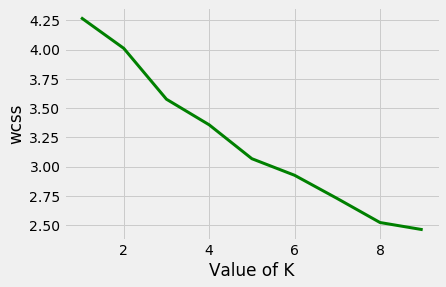

In [32]:
# Set dataframe for clustering, we only need the categories from our one hot encoded dataframe grouped by neighborhood
brooklyn_grouped_clustering = brooklyn_grouped.drop('Neighborhood', 1)

# Create empty array for within cluster sum of squares
wcss = [] 
for i in range(1, 10): 
    KM = KMeans(n_clusters = i, max_iter = 500) 
    KM.fit(brooklyn_grouped_clustering) 
      
    # Calculate within cluster sum of squares using function KM.inertia_ 
    wcss.append(KM.inertia_)      

# Plot the cost against K values 

style.use("fivethirtyeight")
plt.plot(range(1, 10), wcss, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("wcss") 
plt.show()

K-means clustering depends a lot on the initialization of centroids. Since this is set by us and can differ each time, k-means clustering leads to a different result each time we run it (local optimum rather than a global optimum). Here we use the "k-means++" initialization and set the number of times the k-means algorithm will be run with different centroids (n_init) as 12. Scikit learn's "k-means++" initializes the centroids to be (generally) distant from each other, leading to provably better results than random initialization (e.g., random_state). Check out this paper for more information (http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf). 

In [33]:
# Set number of clusters
k = 6

# Run k-means clustering using initialization "k-means++" and number of times k-means will be run with different centroids (n_init) as 12
kmeans = KMeans(init = "k-means++", n_clusters = k, n_init = 12).fit(brooklyn_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 5, 5, 1, 0, 5, 4, 1, 1, 5], dtype=int32)

In [34]:
# Add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

brooklyn_merged = brooklyn

# merge manhattan_grouped with manhattan to add latitude/longitude for each neighborhood
brooklyn_merged = brooklyn_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

brooklyn_merged.head() 

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Brooklyn,Bay Ridge,40.625801,-74.030621,5,Spa,Italian Restaurant,Pizza Place,American Restaurant,Greek Restaurant,Bagel Shop,Bar,Hookah Bar,Pharmacy,Thai Restaurant
1,Brooklyn,Bensonhurst,40.611009,-73.995180,1,Chinese Restaurant,Sushi Restaurant,Ice Cream Shop,Donut Shop,Park,Italian Restaurant,Hotpot Restaurant,Shabu-Shabu Restaurant,Liquor Store,Supermarket
2,Brooklyn,Sunset Park,40.645103,-74.010316,1,Latin American Restaurant,Bakery,Pizza Place,Mobile Phone Shop,Mexican Restaurant,Bank,Pharmacy,Fried Chicken Joint,Gym,Café
3,Brooklyn,Greenpoint,40.730201,-73.954241,5,Bar,Pizza Place,Cocktail Bar,Coffee Shop,Sushi Restaurant,Mexican Restaurant,Café,Yoga Studio,Tea Room,Grocery Store
4,Brooklyn,Gravesend,40.595260,-73.973471,5,Pizza Place,Italian Restaurant,Bakery,Lounge,Eastern European Restaurant,Jewelry Store,Baseball Field,Electronics Store,Sporting Goods Shop,Pharmacy


In [35]:
# Create map of clusters
map_clusters = folium.Map(location=[lat, long], zoom_start=12)

# Set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, long, poi, cluster in zip(brooklyn_merged['Latitude'], brooklyn_merged['Longitude'], brooklyn_merged['Neighborhood'], brooklyn_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=6,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Part 8: Examine Clusters

#### Cluster 1

Cluter 1 includes just 1 neighborhood focused mainly around a marina, playground, and sports facilities / fields. 

In [36]:
# Isolate cluster and include only column 5 onwards
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 0, brooklyn_merged.columns[[1] + list(range(5, brooklyn_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
45,Bergen Beach,Harbor / Marina,Playground,Athletics & Sports,Baseball Field,Women's Store,Fish & Chips Shop,Farm,Farmers Market,Fast Food Restaurant,Field


#### Cluster 2

Cluster 2 focuses on casual eateries, delis / bodegas and local markets, and ice cream shops.

In [37]:
# Isolate cluster and include only columns 5 onwards
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 1, brooklyn_merged.columns[[1] + list(range(5, brooklyn_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Bensonhurst,Chinese Restaurant,Sushi Restaurant,Ice Cream Shop,Donut Shop,Park,Italian Restaurant,Hotpot Restaurant,Shabu-Shabu Restaurant,Liquor Store,Supermarket
2,Sunset Park,Latin American Restaurant,Bakery,Pizza Place,Mobile Phone Shop,Mexican Restaurant,Bank,Pharmacy,Fried Chicken Joint,Gym,Café
5,Brighton Beach,Beach,Eastern European Restaurant,Restaurant,Russian Restaurant,Sushi Restaurant,Bank,Gourmet Shop,Mobile Phone Shop,Mediterranean Restaurant,Supplement Shop
8,Flatbush,Pharmacy,Deli / Bodega,Coffee Shop,Mexican Restaurant,Caribbean Restaurant,Plaza,Juice Bar,Liquor Store,Chinese Restaurant,Lounge
10,East Flatbush,Moving Target,Pharmacy,Caribbean Restaurant,Fast Food Restaurant,Park,Supermarket,Liquor Store,Chinese Restaurant,Food & Drink Shop,Insurance Office
14,Brownsville,Restaurant,Moving Target,Fried Chicken Joint,Pool,Trail,Pizza Place,Performing Arts Venue,Park,Chinese Restaurant,Farmers Market
25,Cypress Hills,Ice Cream Shop,Fast Food Restaurant,Fried Chicken Joint,Latin American Restaurant,Donut Shop,Spanish Restaurant,Seafood Restaurant,Baseball Field,Bank,Supermarket
26,East New York,Deli / Bodega,Fast Food Restaurant,Bus Station,Spanish Restaurant,Fried Chicken Joint,Asian Restaurant,Pizza Place,Pharmacy,Event Service,Caribbean Restaurant
27,Starrett City,Bus Station,Chinese Restaurant,Pizza Place,Moving Target,American Restaurant,Donut Shop,Caribbean Restaurant,Pharmacy,Bus Stop,Liquor Store
29,Flatlands,Pharmacy,Caribbean Restaurant,Fried Chicken Joint,Fast Food Restaurant,Park,Discount Store,Bar,Lounge,Video Store,Paper / Office Supplies Store


#### Cluster 3

Cluster 3 includes only 2 neighborhoods focused on a marina, deli / bodega, public transportation, a gym, and casual eateries. 

In [38]:
# Isolate cluster and include only columns 5 onwards
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 2, brooklyn_merged.columns[[1] + list(range(5, brooklyn_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
28,Canarsie,Deli / Bodega,Bus Line,Gym,Caribbean Restaurant,Asian Restaurant,Thai Restaurant,Food Court,Food & Drink Shop,Food,Farmers Market
59,Paerdegat Basin,Harbor / Marina,Bus Line,Gym,Asian Restaurant,Food,Deli / Bodega,Food Stand,Food Truck,Food Court,Food & Drink Shop


#### Cluster 4

Cluster 4 includes only 1 neighborhood focused on a pool, locksmith, and local markets. 

In [39]:
# Isolate cluster and include only columns 5 onwards
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 3, brooklyn_merged.columns[[1] + list(range(5, brooklyn_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
30,Mill Island,Pool,Locksmith,Fruit & Vegetable Store,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop


#### Cluster 5

Cluster 5 focuses on pizza places, local markets, sports fields, and low-cost eateries. 

In [40]:
# Isolate cluster and include only columns 5 onwards
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 4, brooklyn_merged.columns[[1] + list(range(5, brooklyn_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Manhattan Terrace,Pizza Place,Ice Cream Shop,Donut Shop,Grocery Store,Organic Grocery,Liquor Store,Steakhouse,Coffee Shop,Gym,Bank
34,Borough Park,Bank,Pizza Place,Café,Fast Food Restaurant,Pharmacy,Farmers Market,Hotel,American Restaurant,Deli / Bodega,Coffee Shop
37,Marine Park,Deli / Bodega,Basketball Court,Baseball Field,Chinese Restaurant,Coffee Shop,Athletics & Sports,Gym,Soccer Field,Pizza Place,Ice Cream Shop
46,Midwood,Pizza Place,Ice Cream Shop,Video Game Store,Candy Store,Convenience Store,Pharmacy,Bakery,Donut Shop,Dog Run,Food Truck


#### Cluster 6

Cluster 6 focuses on trendier venues, including bars, restaurants, coffee shops,  galleries, and parks. 

In [41]:
# Isolate cluster and include only columns 5 onwards
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 5, brooklyn_merged.columns[[1] + list(range(5, brooklyn_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bay Ridge,Spa,Italian Restaurant,Pizza Place,American Restaurant,Greek Restaurant,Bagel Shop,Bar,Hookah Bar,Pharmacy,Thai Restaurant
3,Greenpoint,Bar,Pizza Place,Cocktail Bar,Coffee Shop,Sushi Restaurant,Mexican Restaurant,Café,Yoga Studio,Tea Room,Grocery Store
4,Gravesend,Pizza Place,Italian Restaurant,Bakery,Lounge,Eastern European Restaurant,Jewelry Store,Baseball Field,Electronics Store,Sporting Goods Shop,Pharmacy
6,Sheepshead Bay,Dessert Shop,Turkish Restaurant,Harbor / Marina,Sandwich Place,Diner,Creperie,Restaurant,Outlet Store,Russian Restaurant,Café
9,Crown Heights,Pizza Place,Museum,Café,Bakery,Playground,Coffee Shop,Fried Chicken Joint,Supermarket,Candy Store,Sushi Restaurant
11,Kensington,Thai Restaurant,Grocery Store,Pizza Place,Ice Cream Shop,Lingerie Store,Gas Station,Taco Place,Restaurant,Supermarket,Furniture / Home Store
12,Windsor Terrace,Park,Diner,Grocery Store,Plaza,Café,Deli / Bodega,French Restaurant,Bar,Bakery,Thrift / Vintage Store
13,Prospect Heights,Bar,Mexican Restaurant,Bakery,Wine Shop,Thai Restaurant,Café,Coffee Shop,Cocktail Bar,New American Restaurant,Diner
15,Williamsburg,Bar,Coffee Shop,Bagel Shop,Burger Joint,Korean Restaurant,Tapas Restaurant,Latin American Restaurant,Taco Place,Steakhouse,Liquor Store
16,Bushwick,Bar,Mexican Restaurant,Coffee Shop,Deli / Bodega,Discount Store,Bakery,Pizza Place,Thrift / Vintage Store,Café,Vegetarian / Vegan Restaurant
